<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_5m_CNN_LSTM_with_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 4.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=0c0f4c71739bc1310677c67bc42ea242dbaf7e6fbf5586e9991a30eb87a74141
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [5]:
import yfinance as yf
five_m_data = yf.download(tickers='AAPL', period = '60d', interval = '5m')
five_m_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-08-02 09:30:00-04:00,146.360001,146.949997,146.089996,146.419998,146.419998,3930530
2021-08-02 09:35:00-04:00,146.449799,146.449799,145.539993,145.580002,145.580002,2639916
2021-08-02 09:40:00-04:00,145.600006,145.679993,145.270004,145.399994,145.399994,1924389
2021-08-02 09:45:00-04:00,145.500000,145.800003,145.479996,145.689896,145.689896,1643749
2021-08-02 09:50:00-04:00,145.589996,145.739899,145.369995,145.720001,145.720001,1331421
...,...,...,...,...,...,...
2021-10-25 11:45:00-04:00,148.195602,148.360001,148.149994,148.210007,148.210007,383584
2021-10-25 11:50:00-04:00,148.220001,148.399994,148.149994,148.351395,148.351395,392382
2021-10-25 11:55:00-04:00,148.348999,148.520004,148.320007,148.520004,148.520004,391858


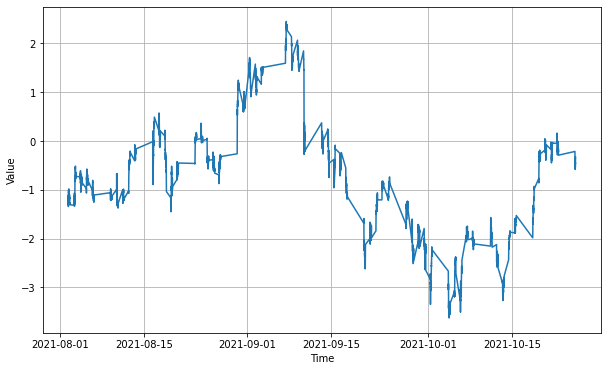

In [7]:
from sklearn.preprocessing import StandardScaler

series = five_m_data['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(five_m_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 3500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3500,)
Epoch 1/100
14/14 [==============================] - 35s 57ms/step - loss: 3.2841 - mae: 3.7410
Epoch 2/100
14/14 [==============================] - 1s 56ms/step - loss: 3.1141 - mae: 3.5741
Epoch 3/100
14/14 [==============================] - 1s 56ms/step - loss: 2.8983 - mae: 3.3615
Epoch 4/100
14/14 [==============================] - 1s 59ms/step - loss: 2.6814 - mae: 3.1479
Epoch 5/100
14/14 [==============================] - 1s 56ms/step - loss: 2.4787 - mae: 2.9486
Epoch 6/100
14/14 [==============================] - 1s 60ms/step - loss: 2.2902 - mae: 2.7597
Epoch 7/100
14/14 [==============================] - 1s 59ms/step - loss: 2.1141 - mae: 2.5807
Epoch 8/100
14/14 [==============================] - 1s 58ms/step - loss: 1.9531 - mae: 2.4153
Epoch 9/100
14/14 [==============================] - 1s 56ms/step - loss: 1.8040 - mae: 2.2612
Epoch 10/100
14/14 [======================

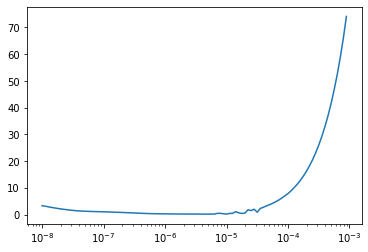

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
35/35 [==============================] - 5s 37ms/step - loss: 0.7135 - mae: 1.1116
Epoch 2/150
35/35 [==============================] - 1s 35ms/step - loss: 0.9825 - mae: 1.4305
Epoch 3/150
35/35 [==============================] - 1s 36ms/step - loss: 0.4353 - mae: 0.8184
Epoch 4/150
35/35 [==============================] - 1s 36ms/step - loss: 0.2976 - mae: 0.6458
Epoch 5/150
35/35 [==============================] - 1s 36ms/step - loss: 0.3362 - mae: 0.7029
Epoch 6/150
35/35 [==============================] - 1s 37ms/step - loss: 0.2213 - mae: 0.5485
Epoch 7/150
35/35 [==============================] - 1s 36ms/step - loss: 0.2368 - mae: 0.5773
Epoch 8/150
35/35 [==============================] - 1s 36ms/step - loss: 0.2661 - mae: 0.6170
Epoch 9/150
35/35 [==============================] - 1s 36ms/step - loss: 0.1337 - mae: 0.4096
Epoch 10/150
35/35 [==============================] - 1s 36ms/step - loss: 0.1760 - mae: 0.4835
Epoch 11/150
35/35 [=============================

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

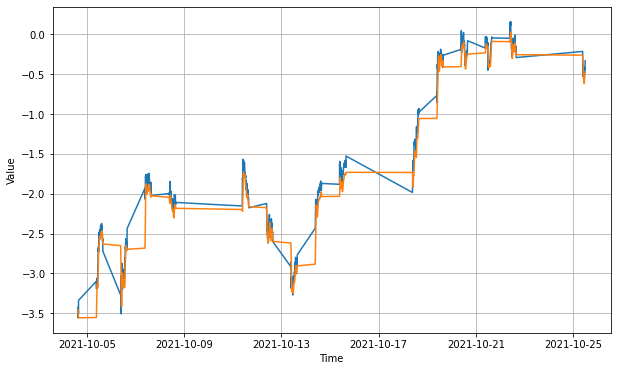

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.9076653

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[ 1.8615248   1.7424954   1.6254276   1.5828438   1.5096529   1.2573298
  1.0262463   1.0331986   0.9170458   0.85491836  0.80024785  0.74824077
  0.8002536   0.89955854  0.9167741   0.95568514  0.98705095  1.0694323
  1.0905286   1.0947118   1.0764086   1.0222079   0.9827543   1.014646
  1.0832359   1.1294173   1.2006402   1.2447231   1.2763056   1.3129449
  1.3696734   1.4225957   1.4376614   1.451085    1.3964739   1.3505807
  1.3507994   1.333136    1.3088098   1.297214    1.3350991   1.4011832
  1.4018337   1.3683496   1.343937    1.3724538   1.4264511   1.472338
  1.4976425   1.5262094   1.5580019   1.5960584   1.7178046   1.8205835
  1.8426906   1.9088467   1.9203616   1.9193264   1.9374311   1.9852957
  2.096164    2.16221     2.1217124   2.0119026   1.9000998   1.8937011
  1.944038    2.0328455   2.0425076   2.028165    2.0922403   2.127544
  2.1277385   2.0989702   2.0168924   1.9688941   1.9599887   1.8887556
  1.8464599   1.8512491   1.880507    1.9644139   2.0015728   2.03